In [54]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [55]:
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical

In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd

In [4]:
# use this cell to make a smaller input file for testing purposes

#d = pd.read_hdf("events.h5")
#np.save('events_small.npy', d[:800000])

In [57]:
d = pd.DataFrame(np.load('events_small.npy'))
d.shape

(800000, 2101)

In [58]:
# masks for bg and signal events
is_bg = (d[2100] == 0)
is_sig = (d[2100] == 1)

In [59]:
print("N_bg  = %d"%np.sum(is_bg))
print("N_sig = %d"%np.sum(is_sig))
print("N_tot = %d"%(np.sum(is_bg) + np.sum(is_sig)))

N_bg  = 727279
N_sig = 72721
N_tot = 800000


In [60]:
# pull out the bg and signal events separately, and reshape to (Nevt, Nparticle, 3)
# the last axis is (pT,eta,phi)

bg = d[is_bg][::2].to_numpy()[:,:-1].reshape((-1,700,3))
sig = d[is_sig].to_numpy()[:,:-1].reshape((-1,700,3))

In [61]:
print(bg.shape)
print(sig.shape)

(363640, 700, 3)
(72721, 700, 3)


In [429]:
# Takes an input of shape (Nevt, Nparticle, 3), and returns a tuple (jets, consts):
# `jets` is a list containing the (pt, eta, phi, m) for the leading jet in each event
# `consts` is a list containing the (pt, eta, phi) for the leading `ntrk` particles in the jet.

def cluster_jets(evts, ntrk=16, pt_min=1600, gev=False, ntrk_min=None):
    ljets = np.zeros((len(evts), 4))
    consts = np.zeros((len(evts), ntrk, 3))
    constspx = np.zeros((len(evts), ntrk, 1))
    constspy = np.zeros((len(evts), ntrk, 1))
    constspz = np.zeros((len(evts), ntrk, 1))
    constspE = np.zeros((len(evts), ntrk, 1))
    
    if ntrk_min is None:
        ntrk_min = ntrk
    
    unit = 1e3 if gev else 1.0
    
    arr = np.zeros(700, dtype=DTYPE_PTEPM)
    for i,evt in enumerate(evts):
        pt = evt[:,0]
        mask = pt>0
        n = np.sum(mask)
        pt = pt[mask]
        eta = evt[:,1][mask]
        phi = evt[:,2][mask]
        pj_input = arr[:n]
        pj_input['pT'] = pt*unit
        pj_input['eta'] = eta
        pj_input['phi'] = phi
        sequence = cluster(pj_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)

        if len(jets) < 1:
            continue
        
        j0 = jets[0]
        
        
        c0 = j0.constituents_array()
        c0[::-1].sort()
        nc = min(c0.shape[0], ntrk)
        
        if c0.shape[0] < ntrk_min:
            continue
            
        ljets[i] = (j0.pt, j0.eta, j0.phi, j0.mass)
        
        consts[i][:nc,0] = c0[:nc]['pT']
        consts[i][:nc,1] = c0[:nc]['eta']
        consts[i][:nc,2] = c0[:nc]['phi']
        constspx[i][:nc,0] = c0[:nc]['pT']*np.cos(c0[:nc]['phi'])
        constspy[i][:nc,0] = c0[:nc]['pT']*np.sin(c0[:nc]['phi'])
        constspz[i][:nc,0] = c0[:nc]['pT']*np.sinh(c0[:nc]['eta'])
        constspE[i][:nc,0] = c0[:nc]['pT']*np.cosh(c0[:nc]['eta'])
        
    sel = ljets[:,0] > pt_min
    ljets = ljets[sel]
    consts = consts[sel]
    constspx = constspx[sel]
    constspy = constspy[sel]
    constspz = constspz[sel]
    constspE = constspE[sel]
    
    return ljets, consts, constspx, constspy, constspz, constspE

In [12]:
# build and return three keras NN models: (classifier, adv, composed)
# The classifier takes `ntrk` constituents from a leading jet, and outputs [0,1]
# The adversary takes `ntrk` constituents, and outputs the same shape with the 4-vectors perturbed
# The composed model is the result of the classifier applied to adversary outputs, i.e. output=adv(cls(input))

def mk_model(ntrk, dropout=0.25):
    K.clear_session()
    
    classifier_input = layers.Input((ntrk,3))
    
    H = classifier_input
    
    H = layers.Flatten()(H)
    
    for _ in range(2):
        H = layers.Dense(128, activation='relu')(H)
        if dropout:
            H = layers.Dropout(dropout)(H)
    
    H = layers.Dense(2, activation='softmax')(H)
    
    classifier = Model(classifier_input, H)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier

## per-event adversarial examples using FGSM

clustering jets
done clustering
Train on 74301 samples, validate on 12707 samples
Epoch 1/64
74301/74301 [==============================] - 4s 56us/step - loss: 0.6784 - acc: 0.5593 - val_loss: 0.6636 - val_acc: 0.5894
Epoch 2/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6596 - acc: 0.5953 - val_loss: 0.6500 - val_acc: 0.6129
Epoch 3/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6471 - acc: 0.6115 - val_loss: 0.6390 - val_acc: 0.6182
Epoch 4/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6378 - acc: 0.6182 - val_loss: 0.6293 - val_acc: 0.6281
Epoch 5/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6310 - acc: 0.6279 - val_loss: 0.6227 - val_acc: 0.6366
Epoch 6/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6265 - acc: 0.6322 - val_loss: 0.6186 - val_acc: 0.6411
Epoch 7/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6241 - acc: 0.6

Epoch 60/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6020 - acc: 0.6526 - val_loss: 0.5974 - val_acc: 0.6586
Epoch 61/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6018 - acc: 0.6530 - val_loss: 0.5951 - val_acc: 0.6611
Epoch 62/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6013 - acc: 0.6534 - val_loss: 0.5957 - val_acc: 0.6611
Epoch 63/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6009 - acc: 0.6526 - val_loss: 0.5991 - val_acc: 0.6540
Epoch 64/64
74301/74301 [==============================] - 4s 54us/step - loss: 0.6013 - acc: 0.6522 - val_loss: 0.5954 - val_acc: 0.6611
FGSM 1/100...
('  avg:', 2, 0.585383)
FGSM 2/100...
('  avg:', 2, 0.5770643)
FGSM 3/100...
('  avg:', 2, 0.5703024)
FGSM 4/100...
('  avg:', 2, 0.5651961)
FGSM 5/100...
('  avg:', 2, 0.56093097)
FGSM 6/100...
('  avg:', 2, 0.5571211)
FGSM 7/100...
('  avg:', 2, 0.5536089)
FGSM 8/100...
('  avg:', 2, 0.5503194

('  avg:', 4, 0.39426562)
FGSM 68/100...
('  avg:', 4, 0.39409474)
FGSM 69/100...
('  avg:', 4, 0.3939456)
FGSM 70/100...
('  avg:', 4, 0.3938165)
FGSM 71/100...
('  avg:', 4, 0.39370736)
FGSM 72/100...
('  avg:', 4, 0.3936222)
FGSM 73/100...
('  avg:', 4, 0.39355794)
FGSM 74/100...
('  avg:', 4, 0.39350834)
FGSM 75/100...
('  avg:', 4, 0.39347592)
FGSM 76/100...
('  avg:', 4, 0.39346433)
FGSM 77/100...
('  avg:', 4, 0.39346752)
FGSM 78/100...
('  avg:', 4, 0.39348227)
FGSM 79/100...
('  avg:', 4, 0.39351246)
FGSM 80/100...
('  avg:', 4, 0.39355525)
FGSM 81/100...
('  avg:', 4, 0.39361173)
FGSM 82/100...
('  avg:', 4, 0.3936853)
FGSM 83/100...
('  avg:', 4, 0.39377263)
FGSM 84/100...
('  avg:', 4, 0.39387545)
FGSM 85/100...
('  avg:', 4, 0.3939903)
FGSM 86/100...
('  avg:', 4, 0.39411822)
FGSM 87/100...
('  avg:', 4, 0.39425525)
FGSM 88/100...
('  avg:', 4, 0.39440453)
FGSM 89/100...
('  avg:', 4, 0.39456135)
FGSM 90/100...
('  avg:', 4, 0.39472875)
FGSM 91/100...
('  avg:', 4, 0.39491

Epoch 50/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4895 - acc: 0.7686 - val_loss: 0.4730 - val_acc: 0.7845
Epoch 51/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4881 - acc: 0.7709 - val_loss: 0.4702 - val_acc: 0.7835
Epoch 52/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4905 - acc: 0.7692 - val_loss: 0.4634 - val_acc: 0.7899
Epoch 53/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4888 - acc: 0.7707 - val_loss: 0.4606 - val_acc: 0.7948
Epoch 54/64
73997/73997 [==============================] - 4s 55us/step - loss: 0.4880 - acc: 0.7705 - val_loss: 0.4662 - val_acc: 0.7863
Epoch 55/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4884 - acc: 0.7712 - val_loss: 0.4707 - val_acc: 0.7862
Epoch 56/64
73997/73997 [==============================] - 4s 54us/step - loss: 0.4860 - acc: 0.7717 - val_loss: 0.4614 - val_acc: 0.7926
Epoch 57/64
73997/73997 [=========

('  avg:', 16, 0.33549348)
FGSM 34/100...
('  avg:', 16, 0.33399147)
FGSM 35/100...
('  avg:', 16, 0.3326188)
FGSM 36/100...
('  avg:', 16, 0.33137766)
FGSM 37/100...
('  avg:', 16, 0.33025903)
FGSM 38/100...
('  avg:', 16, 0.32926)
FGSM 39/100...
('  avg:', 16, 0.3283721)
FGSM 40/100...
('  avg:', 16, 0.327587)
FGSM 41/100...
('  avg:', 16, 0.32691166)
FGSM 42/100...
('  avg:', 16, 0.32633212)
FGSM 43/100...
('  avg:', 16, 0.3258448)
FGSM 44/100...
('  avg:', 16, 0.3254493)
FGSM 45/100...
('  avg:', 16, 0.3251456)
FGSM 46/100...
('  avg:', 16, 0.32492864)
FGSM 47/100...
('  avg:', 16, 0.3247973)
FGSM 48/100...
('  avg:', 16, 0.32473913)
FGSM 49/100...
('  avg:', 16, 0.32474902)
FGSM 50/100...
('  avg:', 16, 0.32482415)
FGSM 51/100...
('  avg:', 16, 0.324963)
FGSM 52/100...
('  avg:', 16, 0.32516465)
FGSM 53/100...
('  avg:', 16, 0.3254243)
FGSM 54/100...
('  avg:', 16, 0.32574248)
FGSM 55/100...
('  avg:', 16, 0.32611382)
FGSM 56/100...
('  avg:', 16, 0.32653764)
FGSM 57/100...
('  av

17206/17206 [==============================] - 1s 55us/step - loss: 0.6998 - acc: 0.5248 - val_loss: 0.6947 - val_acc: 0.5147
Epoch 4/64
17206/17206 [==============================] - 1s 55us/step - loss: 0.6946 - acc: 0.5206 - val_loss: 0.6915 - val_acc: 0.5187
Epoch 5/64
17206/17206 [==============================] - 1s 55us/step - loss: 0.6907 - acc: 0.5309 - val_loss: 0.6930 - val_acc: 0.5277
Epoch 6/64
17206/17206 [==============================] - 1s 56us/step - loss: 0.6883 - acc: 0.5409 - val_loss: 0.6922 - val_acc: 0.5290
Epoch 7/64
17206/17206 [==============================] - 1s 55us/step - loss: 0.6855 - acc: 0.5439 - val_loss: 0.6909 - val_acc: 0.5254
Epoch 8/64
17206/17206 [==============================] - 1s 56us/step - loss: 0.6852 - acc: 0.5409 - val_loss: 0.6904 - val_acc: 0.5163
Epoch 9/64
17206/17206 [==============================] - 1s 56us/step - loss: 0.6826 - acc: 0.5506 - val_loss: 0.6897 - val_acc: 0.5330
Epoch 10/64
17206/17206 [===========================

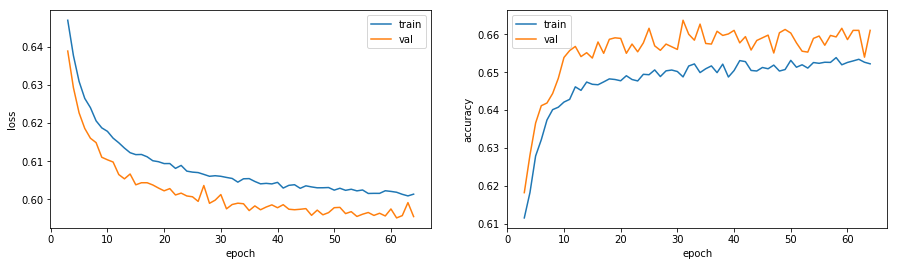

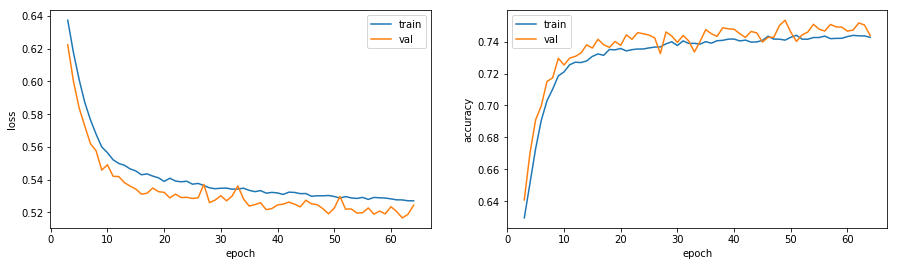

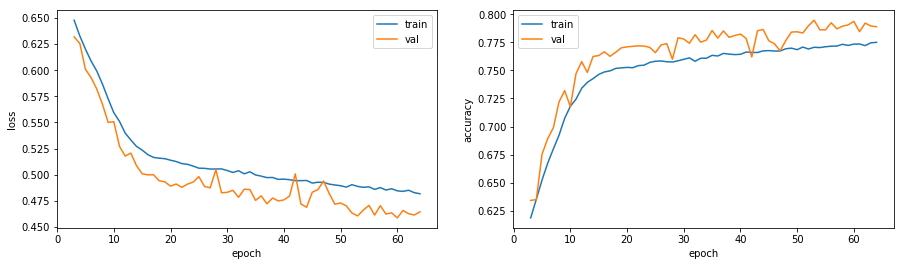

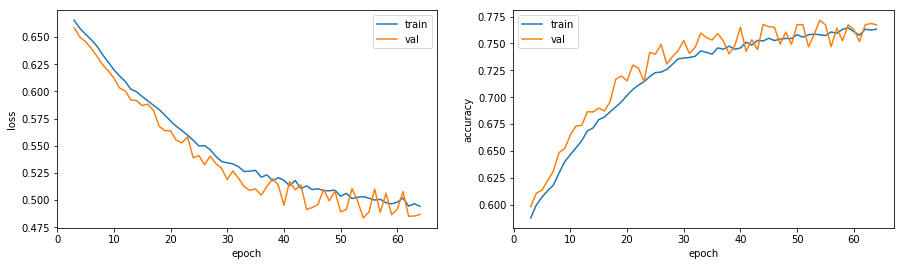

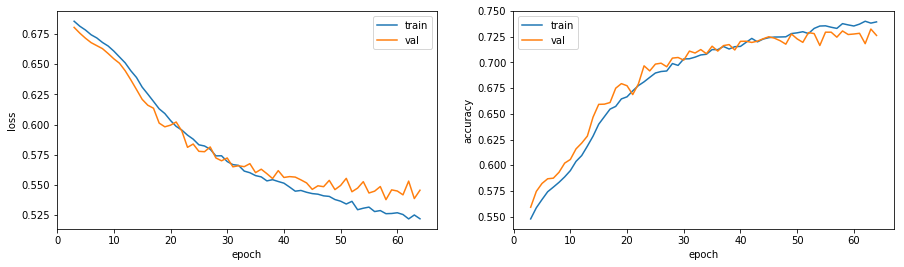

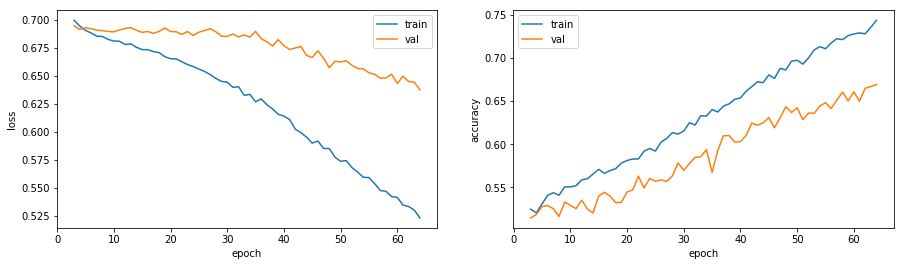

In [14]:
# cluster jets, requiring pT>1.6 TeV

ntrk = 32

yy=[]
for ntrk in [2,4,8,16,32,65]:

    pt_min = 1600

    print "clustering jets"
    bg_jets, bg_consts = cluster_jets(bg, ntrk=ntrk, pt_min=pt_min)
    sig_jets, sig_consts = cluster_jets(sig, ntrk=ntrk, pt_min=pt_min)
    print "done clustering"

    # Format the dataset for input to the NN.
    # First stack to together data from the two classes

    nsig = len(sig_consts)
    nbg = len(bg_consts)
    ncls = min(nsig, nbg)

    X = np.concatenate([bg_consts[:ncls], sig_consts[:ncls]], axis=0).copy()

    # convert pT units to TeV (to limit range of inputs to NN)
    X[:,:,0] /= 1000.

    # make labels for bg (=0) and signal(=1)
    y = np.zeros(X.shape[0], dtype=int)
    y[ncls:] = 1

    # randomly assign 85% of data to training sample, reserve the rest for validation
    is_train = np.random.rand(X.shape[0])<0.85

    X_train = X[is_train]
    y_train = y[is_train]

    X_val = X[~is_train]
    y_val = y[~is_train]



    #Now time for the NN
    classifier = mk_model(ntrk)

    classifier_losses = []
    classifier_val_losses = []
    classifier_acc = []
    classifier_val_acc = []

    # train the signal classifier first
    epochs = 64
    batch_size = 128 #64

    lr = 4e-4

    K.set_value(classifier.optimizer.lr, lr)

    try:
        classifier.fit(X_train, to_categorical(y_train,2),
                  validation_data=(X_val, to_categorical(y_val,2)),
                  batch_size=batch_size, epochs=epochs)
    except KeyboardInterrupt:
        pass

    classifier_losses.extend(classifier.history.history['loss'])
    classifier_val_losses.extend(classifier.history.history['val_loss'])
    classifier_acc.extend(classifier.history.history['acc'])
    classifier_val_acc.extend(classifier.history.history['val_acc'])

    xstart = 2

    xepochs = np.arange(len(classifier_losses))+1

    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(xepochs[xstart:], classifier_losses[xstart:], label='train')
    plt.plot(xepochs[xstart:], classifier_val_losses[xstart:], label='val')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend();

    plt.subplot(122)
    plt.plot(xepochs[xstart:], classifier_acc[xstart:], label='train')
    plt.plot(xepochs[xstart:], classifier_val_acc[xstart:], label='val')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend();

    # pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

    njet = 6000
    target_class = 0

    use_sign = False

    target_name = ['bg', 'signal'][target_class]
    other_name = ['signal','bg'][target_class]

    x = X_val[y_val==target_class][:njet]
    x_adv = x.copy()
    x_noise = np.zeros_like(x)

    prediction_history     = [classifier.predict(x)[:,target_class].mean()]
    prediction_history_quant = [np.quantile(classifier.predict(x)[:,target_class],[0.5,0.68,0.95])]

    # Define the epsilons in the (pt, eta, phi) directions
    epsilons = (5e-5,5e-4,5e-4)
    nstep = 100

    # Then loop for the desired number of iterations to update the adversarial
    # noise using the classifier loss gradient:

    sess = K.get_session()
    epsilon = K.reshape(K.constant(epsilons), (1,1,3))
    yyh=[]
    for istep in range(nstep):
        print("FGSM %d/%d..."%(istep+1,nstep))
        loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), classifier.get_output_at(0))
        grads = K.gradients(loss, classifier.get_input_at(0))

        if use_sign:
            delta = K.sign(grads[0])
        else:
            delta = grads[0]
        x_noise = x_noise + delta

        x_adv = x_adv + epsilon*delta
        x_adv = sess.run(x_adv, feed_dict={classifier.get_input_at(0):x})
        preds = classifier.predict(x_adv)[:,target_class]
        prediction_history.append(preds.mean())
        prediction_history_quant.append(np.quantile(preds, [0.5,0.68,0.9]))
        print("  avg:", ntrk, preds.mean())
        yyh+=[preds.mean()]
        pass
    yy+=[yyh]

In [20]:
firstit = []
for i in range(len(yy)):
    firstit+=[yy[i][0]]
    pass

In [23]:
cross_times = []
for i in range(len(yy)):
    for j in range(len(yy[i])):
        if (yy[i][j] < 0.5):
            cross_times+=[j]
            break
        pass
    pass

In [19]:
nparts = [2,4,8,16,32,65]

Text(0,0.5,'Mean accuracy on first FGSM iteration')

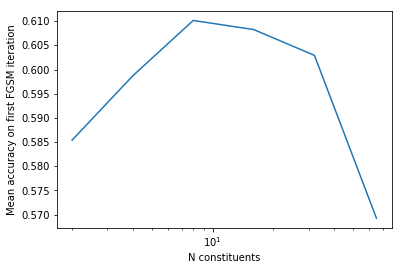

In [27]:
plt.plot(nparts,firstit)
plt.xscale('log')
plt.xlabel("N constituents")
plt.ylabel("Mean accuracy on first FGSM iteration")

Text(0,0.5,'FGSM iterations for mean accuracy to be < 0.5')

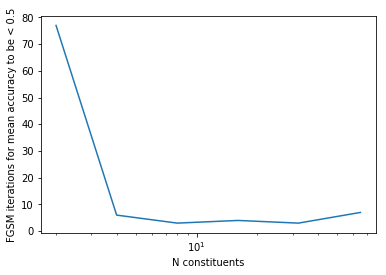

In [28]:
plt.plot(nparts,cross_times)
plt.xscale('log')
plt.xlabel("N constituents")
plt.ylabel("FGSM iterations for mean accuracy to be < 0.5")

In [38]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, Sequential

In [51]:
def mylambda(x):
    return x**3

In [52]:
model = Sequential()
model.add(Dense(1, input_dim=1, activation='linear'))
#model.add(Lambda(lambda x: x ** 2))
model.add(Lambda(mylambda))

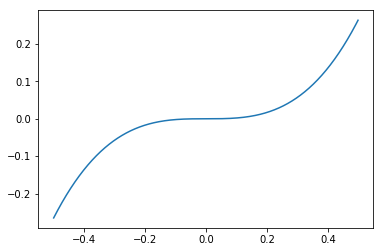

In [53]:
start =-0.5
xvals = []
while start < 0.5:
    xvals+=[start]
    start+=0.001
    pass
fig, ax = plt.subplots()
NNoutput_s = model.predict(np.array(xvals))
ax.plot(xvals, NNoutput_s)

In [467]:
sig_jets, sig_consts, sig_constspx, sig_constspy, sig_constspz, sig_constspE = cluster_jets(sig, 100, pt_min=500.)
bg_jets, bg_consts, bg_constspx, bg_constspy, bg_constspz, bg_constspE = cluster_jets(bg, 100, pt_min=500.)

In [69]:
masses = [x[3] for x in sig_jets]

In [71]:
import matplotlib.pyplot as plt

(array([  24.,   70., 1422.,  559.,  184.,  107.,   38.,   31.,   13.,
           6.]),
 array([ 219.31746708,  325.14389032,  430.97031355,  536.79673678,
         642.62316002,  748.44958325,  854.27600648,  960.10242972,
        1065.92885295, 1171.75527618, 1277.58169942]),
 <a list of 10 Patch objects>)

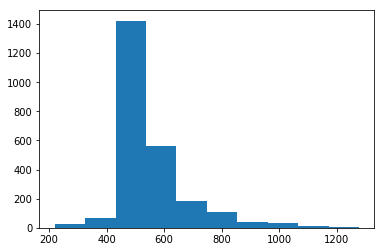

In [73]:
plt.hist(masses)

In [254]:
whichjet = 1
E = 0.
px = 0.
py = 0.
pz = 0.
for i in range(len(sig_consts[whichjet])):
    pTi = sig_consts[whichjet][i][0]
    etai = sig_consts[whichjet][i][1]
    phii = sig_consts[whichjet][i][2]
    E+=pTi*np.cosh(etai)
    px+=pTi*np.cos(phii)
    py+=pTi*np.sin(phii)
    pz+=pTi*np.sinh(etai)
    pass
print(sig_jets[whichjet][0]*np.cos(sig_jets[whichjet][2]),px)
print(sig_jets[whichjet][0]*np.sin(sig_jets[whichjet][2]),py)
print(sig_jets[whichjet][0]*np.sinh(sig_jets[whichjet][1]),pz)
print(sig_jets[whichjet][0]*np.cosh(sig_jets[whichjet][1]),E)
print((E**2 - px**2 - py**2 - pz**2)**0.5,sig_jets[whichjet][3])
#print((px**2+py**2)**0.5)

(-440.45165902500145, -437.83999331127023)
(-1447.908709590458, -1436.8748457832173)
(-502.0842310163313, -499.5485052477167)
(1594.5299841273109, 1658.3924646419953)
(494.37200112745603, 497.9558690682441)


In [450]:
def mymass(x):
    #This one assumes that px,py,pz,E have been concatenated and passed
    px,py,pz,E = tf.split(x,4,axis=1)
    jpx = K.sum(px,axis=1)
    jpy = K.sum(py,axis=1)
    jpz = K.sum(pz,axis=1)
    jpE = K.sum(E,axis=1)
    return K.sqrt(jpE**2-jpx**2-jpy**2-jpz**2) #m
    #return K.sum(K.sqrt(px**2+py**2),axis=1) #pT

In [516]:
def mymass_better(x):
    #this one takes _consts without any modification.
    pT,eta,phi=tf.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = K.sum(pT*tf.cos(phi),axis=1)
    jpy = K.sum(pT*tf.sin(phi),axis=1)
    jpz = K.sum(pT*(0.5*(tf.exp(eta)+tf.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = K.sum(pT*(0.5*(tf.exp(eta)-tf.exp(-eta))),axis=1) #no tf.cosh in my version
    return jpx #K.sqrt(jpE**2-jpx**2-jpy**2-jpz**2) #m
    #return K.sum(K.sqrt(px**2+py**2),axis=1) #pT

In [451]:
model = Sequential()
model.add(Lambda(mymass,input_shape=(400,1),output_shape=(1,)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_51 (Lambda)           (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [517]:
model_better = Sequential()
model_better.add(Lambda(mymass_better,input_shape=(100,3),output_shape=(1,)))
model_better.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_55 (Lambda)           (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [471]:
masses = [x[3] for x in sig_jets]
masses_back = [x[3] for x in bg_jets]

In [470]:
computedm = model.predict(np.array(np.concatenate([sig_constspx,sig_constspy,sig_constspz,sig_constspE],axis=1)))
computedm_back = model.predict(np.array(np.concatenate([bg_constspx,bg_constspy,bg_constspz,bg_constspE],axis=1)))

In [518]:
computedm_better = model_better.predict(sig_consts)

In [521]:
for i in range(5):
    print(computedm_better[i],sig_jets[i][0]*np.cos(sig_jets[i][2]))

(array([1347.7461], dtype=float32), 1362.9921634356874)
(array([-437.84], dtype=float32), -440.45165902500145)
(array([1732.4398], dtype=float32), 1789.288760477743)
(array([87.10621], dtype=float32), 88.0006744152703)
(array([-697.1482], dtype=float32), -701.0889650719057)


Text(0,0.5,'Keras mass [GeV]')

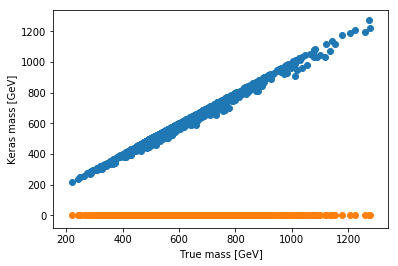

In [514]:
plt.scatter(masses,computedm)
plt.scatter(masses,computedm_better)
#plt.scatter(masses_back,computedm_back)
plt.xlabel('True mass [GeV]')
plt.ylabel('Keras mass [GeV]')

(array([8.34470751e-04, 2.48788722e-03, 2.03086893e-03, 1.22623536e-03,
        5.62297442e-04, 1.83632081e-04, 6.13724128e-05, 1.74656669e-05,
        3.15352319e-06, 1.21289353e-06]),
 array([ 110.95737221,  245.93570849,  380.91404476,  515.89238104,
         650.87071731,  785.84905359,  920.82738987, 1055.80572614,
        1190.78406242, 1325.76239869, 1460.74073497]),
 <a list of 10 Patch objects>)

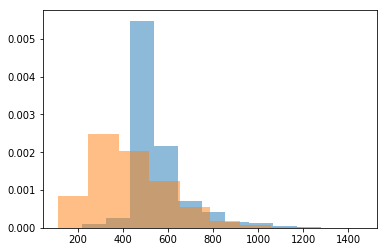

In [481]:
plt.hist(masses,density=True,alpha=0.5)
plt.hist(masses_back,density=True,alpha=0.5)

In [ ]:
njet = 6000
target_class = 0

use_sign = False

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x = X_val[y_val==target_class][:njet]
x_adv = x.copy()
x_noise = np.zeros_like(x)

prediction_history     = [classifier.predict(x)[:,target_class].mean()]
prediction_history_quant = [np.quantile(classifier.predict(x)[:,target_class],[0.5,0.68,0.95])]

# Define the epsilons in the (pt, eta, phi) directions
epsilons = (5e-5,5e-4,5e-4)
nstep = 100

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
yyh=[]
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), classifier.get_output_at(0))
    grads = K.gradients(loss, classifier.get_input_at(0))

    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise = x_noise + delta

    x_adv = x_adv + epsilon*delta
    x_adv = sess.run(x_adv, feed_dict={classifier.get_input_at(0):x})
    preds = classifier.predict(x_adv)[:,target_class]
    prediction_history.append(preds.mean())
    prediction_history_quant.append(np.quantile(preds, [0.5,0.68,0.9]))
    print("  avg:", ntrk, preds.mean())
    yyh+=[preds.mean()]
    pass

In [489]:
pT,eta,phi=tf.split(sig_consts,3,axis=2)

In [491]:
tf.math.cosh(phi)

AttributeError: 'module' object has no attribute 'math'